In [1]:
import numpy as np
import pandas as pd
import random 

from scipy.stats import pearsonr
import itertools

In [2]:
#Define function for obtaining protein-level abundances

def mapPeptidestoProteins(peptide_df):
    
    #Map to proteins using mean across all peptides
    print("Mapping to protein-level using top peptide with highest R2 score")
    new_df_list = []
    all_proteins = np.unique(peptide_df['Protein'].values)

    #Map to proteins by taking the peptide with top R2
    for p in all_proteins:
        #print(p)

        sub_df = peptide_df[peptide_df['Protein'] == p]
        #print(sub_df.shape)
        #print(sub_df)

        top_index = np.argsort(sub_df['R2'].values)[-1]
        new_df = pd.DataFrame(sub_df.iloc[top_index, 12:].values, 
                              index = sub_df.columns[12:], columns = [sub_df['gene symbol'].iloc[top_index]])
        #print(new_df)
        new_df_list.append(new_df)

    peptide_df = pd.concat(new_df_list, axis = 1).T
    print(peptide_df)
    
    #Calculate the average expression of duplicate samples
    print("Calculating mean abundance across duplicate samples")
    all_dfs = []
    i = 0
    while i < peptide_df.shape[1]:
        values1 = peptide_df.iloc[:, i].values
        values2 = peptide_df.iloc[:, i+1].values
        avg_values = (values1 + values2) / 2
        new_df = pd.DataFrame(avg_values, index = peptide_df.index, columns = [peptide_df.columns[i][:-2]])
        all_dfs.append(new_df)
        i = i + 2
    protein_df = pd.concat(all_dfs, axis = 1)
    
    #Rename samples
    sample_names = protein_df.columns
    sample_names = [i.replace(':', '').replace('_', '').replace(' ', '') for i in sample_names]
    protein_df = pd.DataFrame(protein_df.values, index = protein_df.index, 
                           columns = sample_names)
    print(protein_df)

    return protein_df



In [3]:
#Define function for calculating protein complex correlations

def calculateProteinandGeneCorrelations(protein_df, gene_df):
    
    print("Protein df ", protein_df.shape)
    print("Gene df ", gene_df.shape)
    
    #Find common indices
    all_proteins = np.intersect1d(np.array(protein_df.index.values).astype(str), 
                              np.array(gene_df.index.values).astype(str))
    print("Number of common proteins ", len(all_proteins))
    
    protein_df = protein_df.loc[all_proteins]
    new_protein_list = []
    for gene in all_proteins:
        sub_df = protein_df[protein_df.index == gene]
        new_protein_list.append(sub_df.mean(axis = 0))
    protein_df = pd.concat(new_protein_list, axis = 1).T
    protein_df.index = all_proteins
    print(protein_df)
    
    gene_df = gene_df.loc[all_proteins]
    new_gene_list = []
    for gene in all_proteins:
        sub_df = gene_df[gene_df.index == gene]
        new_gene_list.append(sub_df.mean(axis = 0))
    gene_df = pd.concat(new_gene_list, axis = 1).T
    gene_df.index = all_proteins
    print(gene_df)
    
    all_correlations = []
    all_genes = []
    all_proteins = []
    common_samples = np.intersect1d(protein_df.columns, gene_df.columns)
    for sample in common_samples:
        print(sample)

        sub_gene = gene_df[sample].values
        sub_protein = np.log10(protein_df[sample].values + 1e-20)
       
        print(sub_gene)
        print(sub_protein)
        corr, pval =  pearsonr(sub_gene, sub_protein)
        all_correlations.append(corr)
        print(corr)
        print("-------")
        all_genes.append(sub_gene)
        all_proteins.append(sub_protein)
    
    return [all_correlations, all_genes, all_proteins]

In [4]:
#Read gene expression and rename samples
filename = '../preprocess_datasets/preprocessed_datasets/2019_guo_nci60_formatted_mRNA_expression.tsv'

gene_df = pd.read_csv(filename, sep = '\t')
gene_df = gene_df.dropna(how = 'all')
gene_df = gene_df.iloc[:, :-10]
sample_names = gene_df.columns
sample_names = [i.replace(':', '').replace('-', '').replace(' ', '') for i in sample_names]
sample_names[np.where(np.array(sample_names) == 'LCA549/ATCC')[0][0]] = 'LCA549'
sample_names[np.where(np.array(sample_names) == 'LEHL60(TB)')[0][0]] = 'LEHL60'
sample_names[np.where(np.array(sample_names) == 'OVNCI/ADRRES')[0][0]] = 'OVNCIADRRES'
gene_df = pd.DataFrame(gene_df.values, index = gene_df.index, 
                       columns = sample_names)
gene_df.index = gene_df['Genename']
gene_df = gene_df.iloc[:, 7:]
gene_df.values[gene_df.values == '-'] = np.nan
gene_df




/net/noble/vol1/home/abdincer/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,BRMCF7,BRMDAMB231,BRHS578T,BRBT549,BRT47D,CNSSF268,CNSSF295,CNSSF539,CNSSNB19,CNSSNB75,...,PRPC3,PRDU145,RE7860,REA498,REACHN,RECAKI1,RERXF393,RESN12C,RETK10,REUO31
Genename,,,,,,,,,,,,,,,,,,,,,
RAB7B,2.286,2.286,2.286,2.972,2.286,2.286,2.328,2.684,2.286,4.632,...,2.286,2.286,2.286,2.286,2.301,2.36,2.326,2.286,2.286,2.436
LOC100996756,6.262,2.377,2.381,2.286,4.114,2.386,2.443,2.317,3.884,2.374,...,2.35,6.037,2.495,2.286,2.345,2.286,2.373,2.378,2.383,2.29
LOC100996740,2.984,8.166,6.702,3.03,8.655,8.622,8.476,7.424,7.715,6.156,...,6.92,9.093,6.921,7.316,6.539,7.623,8.007,3.774,8.386,8.215
RAB7B,2.287,2.287,2.343,4.001,2.288,2.287,2.322,3.272,2.343,5.396,...,2.287,2.316,2.287,2.483,2.369,2.581,2.51,2.29,2.637,4.007
-,8.505,8.079,8.907,8.07,8.526,7.817,7.962,8.044,8.073,8.087,...,8.575,8.272,8.263,7.482,8.114,7.874,8.022,8.334,8.22,8.048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KIR2DS1,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286,...,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286
KIR2DS1,2.343,2.302,2.286,2.286,2.286,2.286,2.317,2.287,2.286,2.456,...,2.292,2.286,2.286,2.293,2.31,2.286,2.286,2.317,2.286,2.287
MGC70870,6.762,6.542,5.794,6.395,6.532,6.432,6.268,6.322,6.644,5.683,...,6.338,9.453,6.603,6.65,6.844,6.667,6.462,6.556,6.472,6.637


## 1) Measure gene-protein correlations using the original peptide quants 

In [5]:
#Read protein expressions
peptide_df = pd.read_csv('../preprocess_datasets/preprocessed_datasets/2019_guo_nci60_formatted_peptide_quants.tsv',
                          sep = '\t', index_col = 0)
peptide_df.iloc[:, 12:]

,BR_BT549_a,BR_BT549_b,BR_HS578T_a,BR_HS578T_b,BR_MCF7_a,BR_MCF7_b,BR_MDAMB231_a,BR_MDAMB231_b,BR_MDAMB468_a,BR_MDAMB468_b,...,RE_CAKI1_a,RE_CAKI1_b,RE_RXF393_a,RE_RXF393_b,RE_SN12C_a,RE_SN12C_b,RE_TK10_a,RE_TK10_b,RE_UO31_a,RE_UO31_b
1,67736.6,49688.7,57732.7,63349.2,67598.8,61756.7,62153.9,64372.2,128863.4,141989.2,...,184888.7,157024.0,49126.2,52422.3,37285.8,38880.8,179390.0,148828.3,208464.9,183507.2
3,518728.7,533520.9,419320.4,396663.1,317684.0,366097.8,728045.2,703092.6,696036.0,692893.5,...,623419.3,676515.0,521146.7,505380.1,512520.5,588922.3,836327.0,855696.7,844485.0,958940.3
4,104188.8,92525.2,63399.3,58560.5,67032.1,54468.8,86685.3,77341.9,119237.3,111239.7,...,121129.1,111926.1,82168.3,79697.7,86637.4,86046.4,162744.6,140120.6,158263.5,147559.2
5,223566.3,215846.3,118357.8,122532.4,175728.4,164791.1,311832.8,305223.6,352443.2,316824.6,...,332466.8,303315.1,262901.7,219749.2,238151.9,240847.5,381630.9,323716.2,416258.4,358276.0
6,288719.4,234036.4,151627.7,128960.8,180224.5,167356.6,286434.0,319238.4,346288.3,316117.6,...,313338.2,307400.9,267945.1,253036.2,275804.3,244736.9,366880.1,350980.3,423942.9,372984.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22541,73385.3,77362.8,98136.2,94244.5,80880.9,57100.6,84179.0,85921.9,59872.7,72424.7,...,126396.9,115465.7,155045.8,150804.4,91421.7,114228.9,112403.4,117977.3,141709.4,143503.7
22543,6218.5,5104.3,13853.8,11655.2,1221.9,1970.2,7877.3,8134.6,3954.0,3474.4,...,9361.0,7864.9,15023.6,16419.2,8675.6,9419.2,8076.9,7327.0,14040.5,13399.5
22544,47392.5,56741.2,49882.2,58919.8,45155.2,34659.3,52234.9,51076.1,34167.3,27206.7,...,72928.2,60348.4,92661.4,76823.6,53861.6,70917.5,72388.0,67317.0,79469.1,86790.7
22545,248700.6,171957.9,310586.4,289012.3,287223.2,185662.4,310782.2,275944.1,167880.6,271876.2,...,233653.1,323083.7,497715.0,479244.1,274234.3,235873.7,332520.8,247520.0,379462.9,321573.3


In [6]:
protein_df = mapPeptidestoProteins(peptide_df)
protein_df

Mapping to protein-level using top peptide with highest R2 score
         BR_BT549_a BR_BT549_b BR_HS578T_a BR_HS578T_b BR_MCF7_a BR_MCF7_b  \
RBM47        245727     258864      368363      273571    425923    347506   
UBA6         336304     314985     47653.2     47653.2    378437    409848   
KIAA1598    25295.6    33184.4     4271.35     4271.35     75969   69072.3   
ILVBL         70080    71428.3     65681.1     63151.5   86408.3   88170.1   
CNOT1       80054.6      67736     51003.9       58915   92648.8   78550.6   
...             ...        ...         ...         ...       ...       ...   
DYNC1LI1    56654.4    38546.7       67984     65764.5   57762.2   53329.9   
IGF2BP2      4699.8     4699.8       43257     24653.2   21392.6   30993.2   
SLC30A1     2323.55    2323.55     2323.55     2323.55   17787.3   33369.2   
SLC4A7         3370       3370        3370        3370      3370      3370   
SQRDL        167407     171082      193354     98853.2    133980    153572   

,BRBT549,BRHS578T,BRMCF7,BRMDAMB231,BRMDAMB468,BRT47D,CNSSF268,CNSSF295,CNSSF539,CNSSNB19,...,PRDU145,PRPC3,RE7860,REA498,REACHN,RECAKI1,RERXF393,RESN12C,RETK10,REUO31
RBM47,252296,320967,386714,308863,291428,296138,161876,328065,259639,240479,...,231155,240415,260905,342500,376886,289172,306021,276935,378189,313858
UBA6,325644,47653.2,394142,47653.2,47653.2,188435,409606,275465,188715,47653.2,...,47653.2,313214,301022,196918,47653.2,378385,913480,333520,262600,268524
KIAA1598,29240,4271.35,72520.6,40391.6,46675.1,70061.1,20790.5,16165.6,4271.35,26431.7,...,59231.7,56965.2,48695.2,91642.5,45620.2,57368,58032.2,22622.1,56511.7,36624.6
ILVBL,70754.1,64416.3,87289.2,67683.1,56202.6,94685.5,69136.7,92784.1,84796.6,59800.6,...,55716.7,90523.3,53067,77795,79517.4,87116.9,52807.7,58983.2,71772.9,46540.4
CNOT1,73895.3,54959.4,85599.7,75935.9,84310,85241.7,66847.1,75168.6,71384.3,80808.6,...,82381.9,93076.8,79930.5,79205.8,81695.2,66447.1,74478.6,107935,72609,81384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DYNC1LI1,47600.6,66874.2,55546.1,79015.9,66245.1,74297.7,54543.1,45852.7,30125.8,48788.6,...,43012.1,54616.3,61309.7,34960.3,38207.9,32573.1,45544.3,67723.6,47454.8,59677.4
IGF2BP2,4699.8,33955.1,26192.9,62709,19498,4699.8,52965.6,28185.5,64571.5,54474.8,...,47662.6,56812.9,70701.3,23123.2,82021.6,64485.8,53065.7,71571.5,44331.9,115182
SLC30A1,2323.55,2323.55,25578.2,11807.9,12495.9,18025.3,22261.7,2323.55,21213.6,2323.55,...,14038.4,2323.55,2323.55,2323.55,19633.8,34126.1,2323.55,14774.3,20889.6,11535.6
SLC4A7,3370,3370,3370,3370,30050.6,3370,16391.3,190934,43344.7,34310.8,...,54302.7,49571.1,3370,38518.6,26220.1,52986.7,3370,23395.6,19671.1,38641.7


In [7]:
all_correlations_original = calculateProteinandGeneCorrelations(protein_df, gene_df)
all_correlations_original[0]

Protein df  (2122, 60)
Gene df  (54609, 60)
Number of common proteins  2020
           BRBT549     BRHS578T      BRMCF7  BRMDAMB231  BRMDAMB468    BRT47D  \
AAAS       8331.80     64198.00    62750.70    63921.45    77924.55  73633.05   
AAMP      29507.60     24127.85    55001.90    43641.95    43248.30  53778.70   
AARS    5266514.85  10177380.85  1318787.15  3206387.30   287904.30  66078.10   
AARS2     60578.85     48139.65    86841.85    48675.60    72155.90  86774.25   
AASS       1741.65      1741.65    13137.30    40722.90     5765.15   1741.65   
...            ...          ...         ...         ...         ...       ...   
ZNF326    34556.45     22642.95    14805.00    15850.20    24928.30   1216.45   
ZNF428    36109.80     30965.85    60366.75    27403.80    43282.45  16640.00   
ZRANB2    88818.80     52694.05    76352.30    63371.80    90920.20  76989.00   
ZW10      52280.05     64039.65    55645.90    57267.55    45002.55  90398.25   
ZYX      105204.80    189261.25  

[0.3781642271206711,
 0.2989475025562852,
 0.3985139326486291,
 0.36442105730560204,
 0.388649464817828,
 0.35136721254737335,
 0.3553208168889848,
 0.3517982845965708,
 0.3570108117844364,
 0.3373653444017387,
 0.35130694465300466,
 0.38874926157820316,
 0.3563228757237965,
 0.37700394198470666,
 0.38479682267544846,
 0.36074316464747264,
 0.3676111916377382,
 0.39819367234135716,
 0.3668011479162287,
 0.3417246552193449,
 0.3611532544220515,
 0.35358575686240246,
 0.30767469041127593,
 0.40085771235977463,
 0.33285218643211606,
 0.38230035518683325,
 0.3983360491314104,
 0.4397995833320809,
 0.3835240588901655,
 0.42758485139339963,
 0.37121637590271916,
 0.40904441872364133,
 0.4236878050820527,
 0.4124318211187288,
 0.337282894423068,
 0.38295350922431937,
 0.3603601158704795,
 0.37487874887542244,
 0.3456090409643671,
 0.3853065293491249,
 0.3890979429745421,
 0.38786841375250597,
 0.3520693269254742,
 0.37459794174818783,
 0.35832040889982136,
 0.32496663070288195,
 0.33953038347

## 2) Measure protein-gene correlations using the adjusted abundances


In [8]:
#Read protein expressions
peptide_df = pd.read_csv('../preprocess_datasets/preprocessed_datasets/2019_guo_nci60_formatted_peptide_quants.tsv',
                          sep = '\t', index_col = 0)
peptide_df.iloc[:, 12:]


,BR_BT549_a,BR_BT549_b,BR_HS578T_a,BR_HS578T_b,BR_MCF7_a,BR_MCF7_b,BR_MDAMB231_a,BR_MDAMB231_b,BR_MDAMB468_a,BR_MDAMB468_b,...,RE_CAKI1_a,RE_CAKI1_b,RE_RXF393_a,RE_RXF393_b,RE_SN12C_a,RE_SN12C_b,RE_TK10_a,RE_TK10_b,RE_UO31_a,RE_UO31_b
1,67736.6,49688.7,57732.7,63349.2,67598.8,61756.7,62153.9,64372.2,128863.4,141989.2,...,184888.7,157024.0,49126.2,52422.3,37285.8,38880.8,179390.0,148828.3,208464.9,183507.2
3,518728.7,533520.9,419320.4,396663.1,317684.0,366097.8,728045.2,703092.6,696036.0,692893.5,...,623419.3,676515.0,521146.7,505380.1,512520.5,588922.3,836327.0,855696.7,844485.0,958940.3
4,104188.8,92525.2,63399.3,58560.5,67032.1,54468.8,86685.3,77341.9,119237.3,111239.7,...,121129.1,111926.1,82168.3,79697.7,86637.4,86046.4,162744.6,140120.6,158263.5,147559.2
5,223566.3,215846.3,118357.8,122532.4,175728.4,164791.1,311832.8,305223.6,352443.2,316824.6,...,332466.8,303315.1,262901.7,219749.2,238151.9,240847.5,381630.9,323716.2,416258.4,358276.0
6,288719.4,234036.4,151627.7,128960.8,180224.5,167356.6,286434.0,319238.4,346288.3,316117.6,...,313338.2,307400.9,267945.1,253036.2,275804.3,244736.9,366880.1,350980.3,423942.9,372984.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22541,73385.3,77362.8,98136.2,94244.5,80880.9,57100.6,84179.0,85921.9,59872.7,72424.7,...,126396.9,115465.7,155045.8,150804.4,91421.7,114228.9,112403.4,117977.3,141709.4,143503.7
22543,6218.5,5104.3,13853.8,11655.2,1221.9,1970.2,7877.3,8134.6,3954.0,3474.4,...,9361.0,7864.9,15023.6,16419.2,8675.6,9419.2,8076.9,7327.0,14040.5,13399.5
22544,47392.5,56741.2,49882.2,58919.8,45155.2,34659.3,52234.9,51076.1,34167.3,27206.7,...,72928.2,60348.4,92661.4,76823.6,53861.6,70917.5,72388.0,67317.0,79469.1,86790.7
22545,248700.6,171957.9,310586.4,289012.3,287223.2,185662.4,310782.2,275944.1,167880.6,271876.2,...,233653.1,323083.7,497715.0,479244.1,274234.3,235873.7,332520.8,247520.0,379462.9,321573.3


In [9]:
#Read coefficients and adjust the abundances
coeff_df = pd.read_csv('../trained_models/2019_guo_nci60/2019_guo_nci60_inferred_coefficients.tsv', sep = '\t', index_col = 0)
print(coeff_df)

adjusted_abundances = peptide_df.iloc[:, 12:].values / coeff_df.values
adjusted_abundances = pd.DataFrame(adjusted_abundances, 
                                   index =  peptide_df.index, 
                                   columns =  peptide_df.columns[12:])

peptide_df.iloc[:, 12:] = adjusted_abundances
peptide_df

              0
1      1.255469
3      1.754560
4      0.540061
5      1.245843
6      0.739107
...         ...
22541  1.467804
22543  0.585922
22544  0.488067
22545  0.796018
22546  0.643969

[14472 rows x 1 columns]


,Peptide,Protein,gene symbol,R2,best mscore,numNA,Charge 1,Charge 2,Charge 3,Charge 4,...,RE_CAKI1_a,RE_CAKI1_b,RE_RXF393_a,RE_RXF393_b,RE_SN12C_a,RE_SN12C_b,RE_TK10_a,RE_TK10_b,RE_UO31_a,RE_UO31_b
1,VHCCFYFISPFGHGLKPLDVAFMK,Q15019,2-Sep,0.935026,1.920000e-07,4,0,0,0,0,...,147266.674191,125072.014938,39129.768827,41755.162833,29698.709335,30969.151202,142886.875635,118544.014678,166045.477677,146166.288335
3,VNIVPVIAK,Q15019,2-Sep,0.917310,4.010000e-09,0,0,1,0,0,...,355313.713374,385575.256979,297024.120347,288038.050789,292107.674618,335652.376020,476659.051083,487698.683693,481308.649313,546541.691758
4,QQPTQFINPETPGYVGFANLPNQVHR,Q15019,2-Sep,0.897582,2.160000e-08,0,0,0,1,0,...,224287.961441,207247.282453,152146.433038,147571.761571,160421.614876,159327.293320,301345.048956,259453.456930,293047.647390,273227.095387
5,STLINSLFLTDLYPER,Q15019,2-Sep,0.893410,1.060000e-08,0,0,1,0,0,...,266860.826971,243461.658183,211023.070797,176385.892481,191157.171118,193320.845943,306323.330846,259836.990749,334117.755089,287577.074294
6,ASIPFSVVGSNQLIEAK,Q15019,2-Sep,0.882319,9.200000e-09,0,0,1,0,0,...,423941.364949,415908.296954,362525.256817,342353.763472,373158.623496,331124.948823,496382.663737,474870.499199,573587.681574,504641.815249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22541,CSVCSEPIMPEPGRDETVR,Q15942,ZYX,0.876235,8.910000e-07,2,0,0,1,0,...,86112.927884,78665.612030,105631.133312,102741.510447,62284.678336,77822.992716,76579.298053,80376.739674,96545.179057,97767.617475
22543,QHPVPPPAQNQNQVR,Q15942,ZYX,0.848883,7.970000e-05,14,0,1,0,0,...,15976.518392,13423.108589,25640.938117,28022.823500,14806.738913,16075.848952,13784.931247,12505.068931,23963.070878,22869.069351
22544,ALGQLFHIACFTCHQCAQQLQGQQFYSLEGAPYCEGCYTDTLEK,Q15942,ZYX,0.813338,7.390000e-08,2,0,0,0,0,...,149422.435149,123647.709464,189853.747005,157403.711992,110356.918627,145302.716160,148315.620509,137925.659305,162824.071362,177825.282158
22545,VSSGYVPPPVATPFSSK,Q15942,ZYX,0.649288,1.230000e-07,12,0,1,0,0,...,293527.481421,405874.969128,625256.118645,602051.989290,344507.748445,296317.117532,417730.357286,310947.820514,476701.526021,403977.524121


In [10]:
protein_df = mapPeptidestoProteins(peptide_df)
all_correlations_adjusted = calculateProteinandGeneCorrelations(protein_df, gene_df)
all_correlations_adjusted[0]

Mapping to protein-level using top peptide with highest R2 score
         BR_BT549_a BR_BT549_b BR_HS578T_a BR_HS578T_b BR_MCF7_a BR_MCF7_b  \
RBM47        257149     270896      385485      286287    445721    363658   
UBA6         228109     213649     32322.4     32322.4    256688    277993   
KIAA1598    26495.7    34758.8     4473.99     4473.99   79573.2   72349.3   
ILVBL         63998    65229.3     59980.9     57670.8   78909.2   80518.1   
CNOT1       48789.6      41282     31084.6       35906   56465.2     47873   
...             ...        ...         ...         ...       ...       ...   
DYNC1LI1    64938.7    44183.2       77925       75381   66208.5   61128.1   
IGF2BP2     4808.69    4808.69     44259.3     25224.4   21888.3   31711.3   
SLC30A1     2195.32    2195.32     2195.32     2195.32   16805.7   31527.7   
SLC4A7      3980.23    3980.23     3980.23     3980.23   3980.23   3980.23   
SQRDL        115582     118120      133497     68250.7   92503.2    106030   

         BRMCF7  BRMDAMB231  BRHS578T   BRBT549   BRT47D  CNSSF268  CNSSF295  \
AAAS     7.1320     5.83600   6.27000   5.94600   7.2960   6.14500    6.3620   
AAMP     9.1360     8.71800   9.19300   7.58100   8.3940   8.50300    8.4780   
AARS    11.6500     9.20500  11.73500  11.32600  12.1530  10.59200   10.6010   
AARS2    6.5015     6.47300   5.33650   5.80000   6.2555   6.02400    6.0200   
AASS     2.3750     5.41850   4.23450   2.43150   2.9500   7.18600    4.9245   
...         ...         ...       ...       ...      ...       ...       ...   
ZNF326   4.2450     4.47675   4.27475   5.06225   4.0780   4.87625    4.7050   
ZNF428   4.4540     4.12350   4.08300   4.33700   3.8180   4.33800    4.4100   
ZRANB2   8.9305     8.61700   9.62450  10.09700   9.4620   8.85050    9.5380   
ZW10     6.2180     8.01000   6.58400   7.16400   7.3650   7.44600    6.6170   
ZYX      5.5890     7.47000   8.46350   7.95150   4.9270   7.46550    8.6290   

        CNSSF539  CNSSNB19  CNSSNB75  .

[0.39275335331721706,
 0.31465644913870927,
 0.4150297377636869,
 0.3828089477019416,
 0.4037426136386628,
 0.3660094983880017,
 0.3716947052743268,
 0.36442866154751974,
 0.37860487464061654,
 0.35848455818568004,
 0.37184257870332593,
 0.40314407691463444,
 0.36588695624839285,
 0.3954334008625715,
 0.3988243677201305,
 0.37399247566349225,
 0.38511160298084707,
 0.41907313155550385,
 0.382433842102504,
 0.3615495505764199,
 0.38033293624598835,
 0.37377708024013634,
 0.32151147464737706,
 0.4182967251594877,
 0.3519607167955848,
 0.3946570702120517,
 0.4162869463064126,
 0.45684675807668385,
 0.39703823299586594,
 0.44318047942382827,
 0.37709646964357685,
 0.42602972106724757,
 0.44161655714331727,
 0.43311780471230366,
 0.36031814126354905,
 0.4035372151411111,
 0.3772268533567855,
 0.39408317807412885,
 0.364881432034204,
 0.4074926336027059,
 0.4118651608138458,
 0.407740578363129,
 0.37106785385390617,
 0.39514172956539684,
 0.3745656577349171,
 0.34191499707154427,
 0.35915932

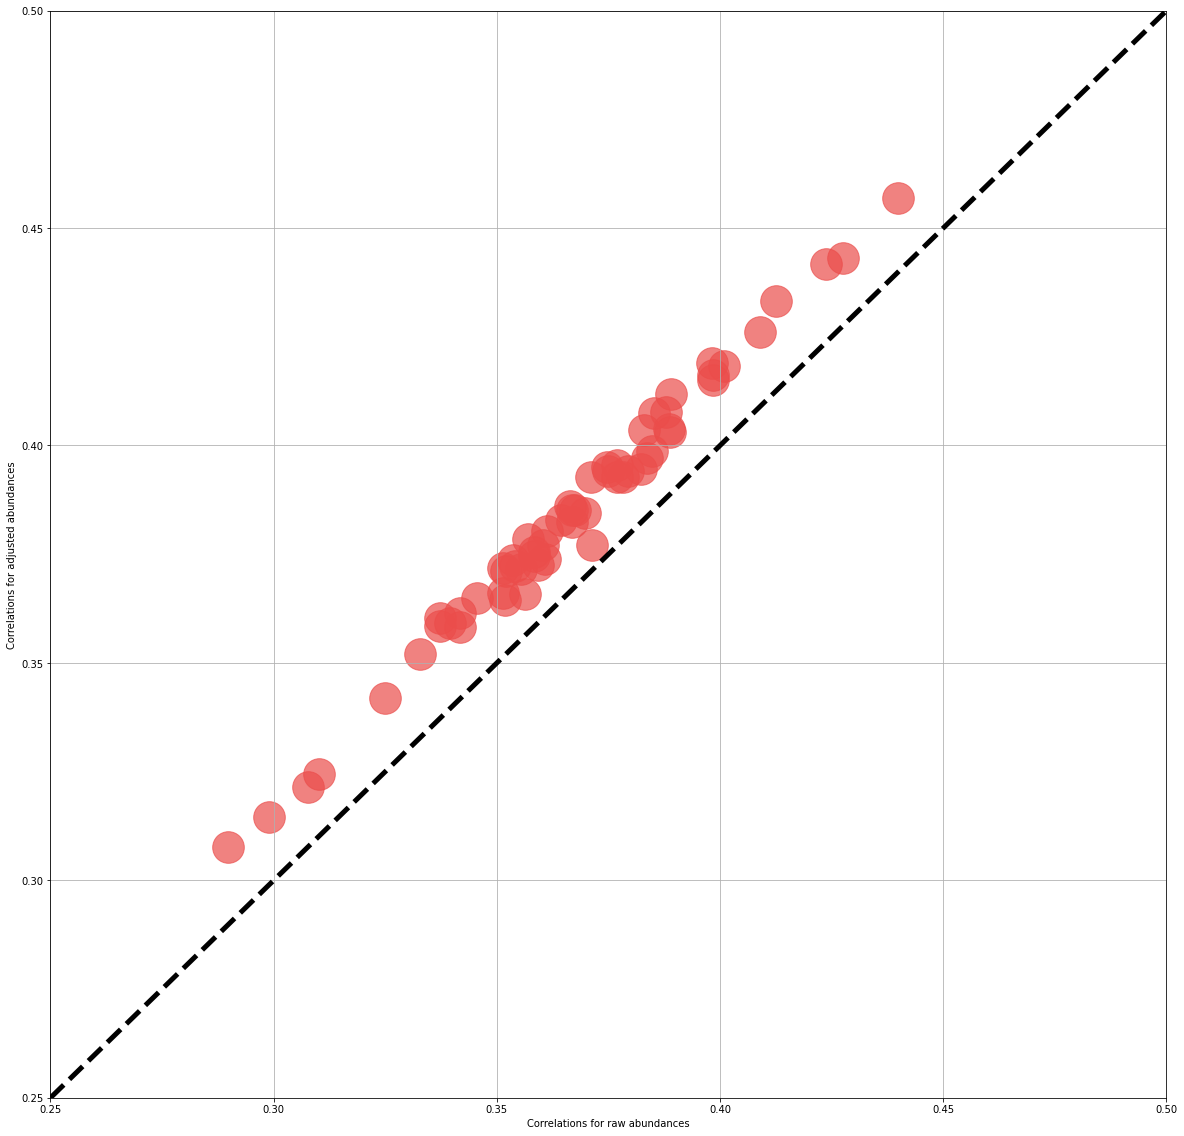

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(20, 20)

SMALL_SIZE = 30
MEDIUM_SIZE = 60
BIGGER_SIZE = 70

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.scatter(np.array(all_correlations_original[0]), 
            np.array(all_correlations_adjusted[0]),
            s = 1000, color = '#eb4d4b', alpha = 0.7)

plt.plot([0.25, 0.5], [0.25, 0.5], '--', lw = 5, color = 'Black')
plt.xlim([0.25, 0.5])
plt.ylim([0.25, 0.5])
plt.xlabel('Correlations for raw abundances')
plt.ylabel('Correlations for adjusted abundances')
#plt.title('Comparison of gene-protein correlations \n for raw and adjusted abundances')
plt.grid()




In [12]:
from scipy import stats
stats.wilcoxon(np.array(all_correlations_adjusted[0]) - np.array(all_correlations_original[0]), alternative = 'greater')


WilcoxonResult(statistic=1770.0, pvalue=1.1950476758489101e-11)

# Try with randomly generated coefficients

In [13]:
#Read original peptide quants
peptide_df = pd.read_csv('../preprocess_datasets/preprocessed_datasets/2019_guo_nci60_formatted_peptide_quants.tsv',
                          sep = '\t', index_col = 0)

#Small test with completely random coefficients
coeff_df = np.random.uniform(low=0.1, high=1.0, size=(peptide_df.shape[0], 1))
print(coeff_df)

adjusted_abundances = peptide_df.iloc[:, 12:].values / coeff_df
adjusted_abundances = pd.DataFrame(adjusted_abundances, 
                                   index =  peptide_df.index, 
                                   columns =  peptide_df.columns[12:])

peptide_df.iloc[:, 12:] = adjusted_abundances
peptide_df

[[0.78491657]
 [0.15214711]
 [0.48186084]
 ...
 [0.79398954]
 [0.19549418]
 [0.48384288]]


,Peptide,Protein,gene symbol,R2,best mscore,numNA,Charge 1,Charge 2,Charge 3,Charge 4,...,RE_CAKI1_a,RE_CAKI1_b,RE_RXF393_a,RE_RXF393_b,RE_SN12C_a,RE_SN12C_b,RE_TK10_a,RE_TK10_b,RE_UO31_a,RE_UO31_b
1,VHCCFYFISPFGHGLKPLDVAFMK,Q15019,2-Sep,0.935026,1.920000e-07,4,0,0,0,0,...,2.355520e+05,2.000518e+05,6.258780e+04,6.678710e+04,4.750288e+04,4.953495e+04,2.285466e+05,1.896103e+05,2.655886e+05,2.337920e+05
3,VNIVPVIAK,Q15019,2-Sep,0.917310,4.010000e-09,0,0,1,0,0,...,4.097477e+06,4.446453e+06,3.425282e+06,3.321654e+06,3.368585e+06,3.870742e+06,5.496831e+06,5.624140e+06,5.550450e+06,6.302718e+06
4,QQPTQFINPETPGYVGFANLPNQVHR,Q15019,2-Sep,0.897582,2.160000e-08,0,0,0,1,0,...,2.513778e+05,2.322789e+05,1.705229e+05,1.653957e+05,1.797976e+05,1.785711e+05,3.377419e+05,2.907906e+05,3.284423e+05,3.062278e+05
5,STLINSLFLTDLYPER,Q15019,2-Sep,0.893410,1.060000e-08,0,0,1,0,0,...,1.392952e+06,1.270814e+06,1.101492e+06,9.206937e+05,9.977963e+05,1.009090e+06,1.598937e+06,1.356289e+06,1.744018e+06,1.501086e+06
6,ASIPFSVVGSNQLIEAK,Q15019,2-Sep,0.882319,9.200000e-09,0,0,1,0,0,...,4.999997e+05,4.905254e+05,4.275650e+05,4.037746e+05,4.401061e+05,3.905313e+05,5.854375e+05,5.600659e+05,6.764937e+05,5.951784e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22541,CSVCSEPIMPEPGRDETVR,Q15942,ZYX,0.876235,8.910000e-07,2,0,0,1,0,...,4.667325e+05,4.263680e+05,5.725213e+05,5.568596e+05,3.375833e+05,4.218010e+05,4.150602e+05,4.356424e+05,5.232754e+05,5.299010e+05
22543,QHPVPPPAQNQNQVR,Q15942,ZYX,0.848883,7.970000e-05,14,0,1,0,0,...,1.460351e+04,1.226954e+04,2.343738e+04,2.561457e+04,1.353426e+04,1.469431e+04,1.260027e+04,1.143040e+04,2.190371e+04,2.090373e+04
22544,ALGQLFHIACFTCHQCAQQLQGQQFYSLEGAPYCEGCYTDTLEK,Q15942,ZYX,0.813338,7.390000e-08,2,0,0,0,0,...,9.185033e+04,7.600654e+04,1.167036e+05,9.675644e+04,6.783666e+04,8.931793e+04,9.116997e+04,8.478323e+04,1.000883e+05,1.093096e+05
22545,VSSGYVPPPVATPFSSK,Q15942,ZYX,0.649288,1.230000e-07,12,0,1,0,0,...,1.195192e+06,1.652651e+06,2.545933e+06,2.451450e+06,1.402775e+06,1.206551e+06,1.700924e+06,1.266125e+06,1.941045e+06,1.644925e+06


In [14]:
protein_df = mapPeptidestoProteins(peptide_df)
all_correlations_random = calculateProteinandGeneCorrelations(protein_df, gene_df)
all_correlations_random[0]

Mapping to protein-level using top peptide with highest R2 score
         BR_BT549_a BR_BT549_b  BR_HS578T_a  BR_HS578T_b    BR_MCF7_a  \
RBM47        935019     985004  1.40166e+06  1.04097e+06  1.62068e+06   
UBA6         642798     602050      91082.4      91082.4       723331   
KIAA1598    27073.9    35517.3      4571.64      4571.64      81309.8   
ILVBL        125066     127472       117215       112701       154206   
CNOT1        208419     176348       132787       153383       241207   
...             ...        ...          ...          ...          ...   
DYNC1LI1    57841.3    39354.2      69408.2      67142.2      58972.3   
IGF2BP2     4926.39    4926.39      45342.5      25841.8        22424   
SLC30A1     6737.64    6737.64      6737.64      6737.64      51578.2   
SLC4A7       5397.9     5397.9       5397.9       5397.9       5397.9   
SQRDL        277170     283255       320130       163668       221826   

           BR_MCF7_b BR_MDAMB231_a BR_MDAMB231_b BR_MDAMB4

         BRMCF7  BRMDAMB231  BRHS578T   BRBT549   BRT47D  CNSSF268  CNSSF295  \
AAAS     7.1320     5.83600   6.27000   5.94600   7.2960   6.14500    6.3620   
AAMP     9.1360     8.71800   9.19300   7.58100   8.3940   8.50300    8.4780   
AARS    11.6500     9.20500  11.73500  11.32600  12.1530  10.59200   10.6010   
AARS2    6.5015     6.47300   5.33650   5.80000   6.2555   6.02400    6.0200   
AASS     2.3750     5.41850   4.23450   2.43150   2.9500   7.18600    4.9245   
...         ...         ...       ...       ...      ...       ...       ...   
ZNF326   4.2450     4.47675   4.27475   5.06225   4.0780   4.87625    4.7050   
ZNF428   4.4540     4.12350   4.08300   4.33700   3.8180   4.33800    4.4100   
ZRANB2   8.9305     8.61700   9.62450  10.09700   9.4620   8.85050    9.5380   
ZW10     6.2180     8.01000   6.58400   7.16400   7.3650   7.44600    6.6170   
ZYX      5.5890     7.47000   8.46350   7.95150   4.9270   7.46550    8.6290   

        CNSSF539  CNSSNB19  CNSSNB75  .

[0.32960855621654495,
 0.25460195682112113,
 0.34740266299195877,
 0.3073023055699151,
 0.3401297707680936,
 0.3042973190620884,
 0.3087019898396166,
 0.30302860609512705,
 0.3096443045349535,
 0.29163225672398246,
 0.30235594333928817,
 0.3396887930898118,
 0.3047382644487928,
 0.3238182779915516,
 0.33117150465608947,
 0.30356629676721314,
 0.3175168798529794,
 0.334975217690585,
 0.31680419284885997,
 0.28969904857262707,
 0.30594305461956695,
 0.29562614215465677,
 0.2669281129397201,
 0.34653334442091605,
 0.2797297454424114,
 0.33393316863110495,
 0.3449332758422966,
 0.38801455599136,
 0.3411211304351997,
 0.3768191192998575,
 0.3404468074940209,
 0.36099698467126196,
 0.37319618712652514,
 0.35954410923532765,
 0.291841279644038,
 0.3367315907612995,
 0.3143449642241235,
 0.31939746991256934,
 0.30172015371454214,
 0.33918231151341693,
 0.3392331757377461,
 0.33709270733728797,
 0.3019530384030318,
 0.3215312526604842,
 0.3085349306112657,
 0.27820231070857815,
 0.2848478538728

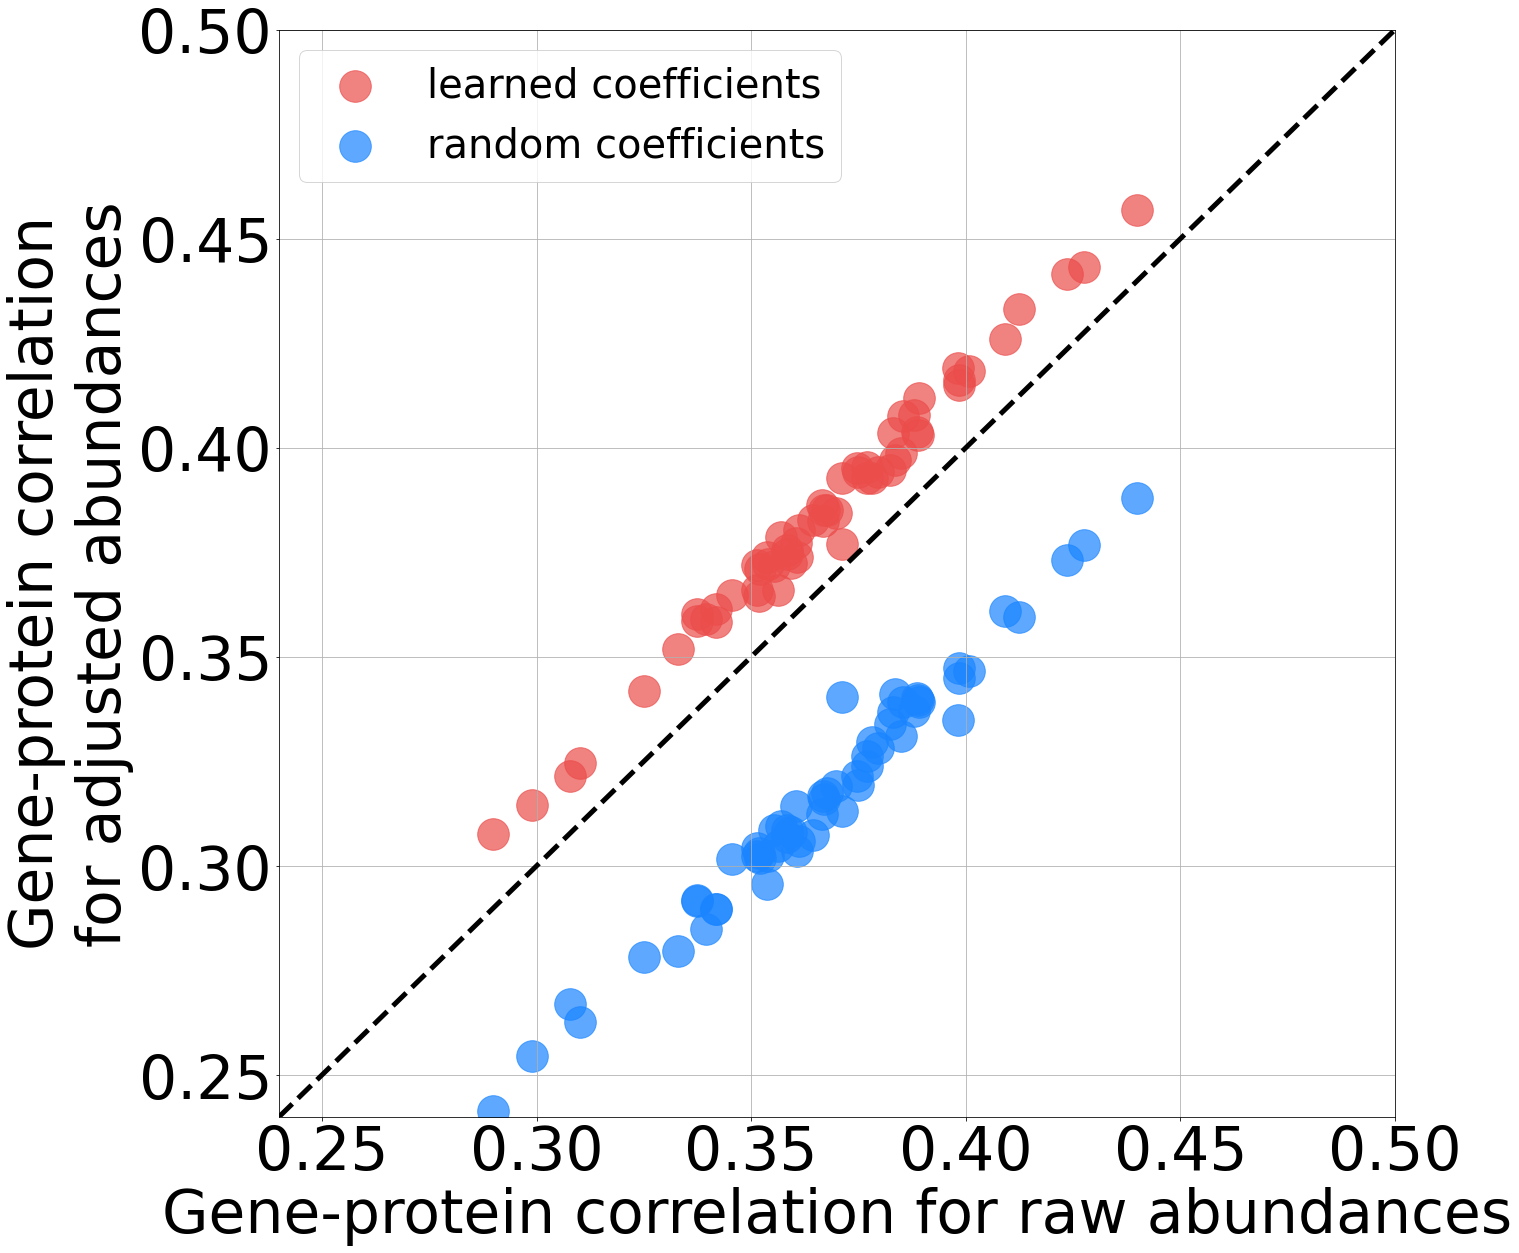

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(20, 20)

SMALL_SIZE = 40
MEDIUM_SIZE = 60
BIGGER_SIZE = 70

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.scatter(np.array(all_correlations_original[0]), 
            np.array(all_correlations_adjusted[0]),
            s = 1000, color = '#eb4d4b', alpha = 0.7, label = 'learned coefficients')

plt.scatter(np.array(all_correlations_original[0]), 
            np.array(all_correlations_random[0]),
            s = 1000, color = '#1A85FF', alpha = 0.7, label = 'random coefficients')


plt.plot([0.24, 0.5], [0.24, 0.5], '--', lw = 5, color = 'Black')
plt.xlim([0.24, 0.5])
plt.ylim([0.24, 0.5])
plt.legend()
plt.xlabel('Gene-protein correlation for raw abundances')
plt.ylabel('Gene-protein correlation \nfor adjusted abundances')
plt.grid()




In [16]:
#Read coefficients and adjust the abundances
coeff_df = pd.read_csv('../trained_models/2019_guo_nci60/2019_guo_nci60_inferred_coefficients.tsv', sep = '\t', index_col = 0)
print(coeff_df)

random_coeffs = coeff_df.values
np.random.shuffle(random_coeffs)
adjusted_abundances = peptide_df.iloc[:, 11:].values / random_coeffs
adjusted_abundances = pd.DataFrame(adjusted_abundances, 
                                   index =  peptide_df.index, 
                                   columns =  peptide_df.columns[11:])

peptide_df.iloc[:, 11:] = adjusted_abundances
peptide_df

              0
1      1.255469
3      1.754560
4      0.540061
5      1.245843
6      0.739107
...         ...
22541  1.467804
22543  0.585922
22544  0.488067
22545  0.796018
22546  0.643969

[14472 rows x 1 columns]


,Peptide,Protein,gene symbol,R2,best mscore,numNA,Charge 1,Charge 2,Charge 3,Charge 4,...,RE_CAKI1_a,RE_CAKI1_b,RE_RXF393_a,RE_RXF393_b,RE_SN12C_a,RE_SN12C_b,RE_TK10_a,RE_TK10_b,RE_UO31_a,RE_UO31_b
1,VHCCFYFISPFGHGLKPLDVAFMK,Q15019,2-Sep,0.935026,1.920000e-07,4,0,0,0,0,...,1.637024e+05,1.390307e+05,4.349685e+04,4.641526e+04,3.301324e+04,3.442547e+04,1.588338e+05,1.317741e+05,1.845770e+05,1.624792e+05
3,VNIVPVIAK,Q15019,2-Sep,0.917310,4.010000e-09,0,0,1,0,0,...,3.417131e+06,3.708163e+06,2.856547e+06,2.770126e+06,2.809264e+06,3.228044e+06,4.584136e+06,4.690307e+06,4.628852e+06,5.256213e+06
4,QQPTQFINPETPGYVGFANLPNQVHR,Q15019,2-Sep,0.897582,2.160000e-08,0,0,0,1,0,...,2.129555e+05,1.967758e+05,1.444590e+05,1.401155e+05,1.523161e+05,1.512770e+05,2.861191e+05,2.463442e+05,2.782410e+05,2.594219e+05
5,STLINSLFLTDLYPER,Q15019,2-Sep,0.893410,1.060000e-08,0,0,1,0,0,...,8.668645e+05,7.908552e+05,6.854824e+05,5.729678e+05,6.209505e+05,6.279789e+05,9.950536e+05,8.440484e+05,1.085340e+06,9.341587e+05
6,ASIPFSVVGSNQLIEAK,Q15019,2-Sep,0.882319,9.200000e-09,0,0,1,0,0,...,7.298935e+05,7.160631e+05,6.241543e+05,5.894254e+05,6.424616e+05,5.700929e+05,8.546146e+05,8.175775e+05,9.875374e+05,8.688343e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22541,CSVCSEPIMPEPGRDETVR,Q15942,ZYX,0.876235,8.910000e-07,2,0,0,1,0,...,2.329671e+05,2.128194e+05,2.857710e+05,2.779536e+05,1.685030e+05,2.105398e+05,2.071752e+05,2.174486e+05,2.611902e+05,2.644973e+05
22543,QHPVPPPAQNQNQVR,Q15942,ZYX,0.848883,7.970000e-05,14,0,1,0,0,...,1.179136e+04,9.906829e+03,1.892411e+04,2.068204e+04,1.092801e+04,1.186467e+04,1.017387e+04,9.229277e+03,1.768577e+04,1.687835e+04
22544,ALGQLFHIACFTCHQCAQQLQGQQFYSLEGAPYCEGCYTDTLEK,Q15942,ZYX,0.813338,7.390000e-08,2,0,0,0,0,...,6.875937e+04,5.689868e+04,8.736455e+04,7.243210e+04,5.078268e+04,6.686361e+04,6.825005e+04,6.346893e+04,7.492637e+04,8.182944e+04
22545,VSSGYVPPPVATPFSSK,Q15942,ZYX,0.649288,1.230000e-07,12,0,1,0,0,...,1.207724e+06,1.669980e+06,2.572627e+06,2.477154e+06,1.417483e+06,1.219202e+06,1.718759e+06,1.279400e+06,1.961397e+06,1.662173e+06


In [17]:
protein_df_adjusted = mapPeptidestoProteins(peptide_df)
all_correlations_random = calculateProteinandGeneCorrelations(protein_df_adjusted, gene_df)
all_correlations_random[0]

Mapping to protein-level using top peptide with highest R2 score
           BR_BT549_a   BR_BT549_b  BR_HS578T_a BR_HS578T_b    BR_MCF7_a  \
RBM47          798277       840951  1.19668e+06      888729  1.38367e+06   
UBA6      1.12768e+06  1.05619e+06       159788      159788  1.26896e+06   
KIAA1598      21316.7      27964.6      3599.48     3599.48      64019.2   
ILVBL         91842.1        93609      86077.2       82762       113241   
CNOT1          171380       145009       109189      126125       198342   
...               ...          ...          ...         ...          ...   
DYNC1LI1      49565.2      33723.4      59477.2     57535.4      50534.4   
IGF2BP2       4742.15      4742.15      43646.8     24875.3      21585.4   
SLC30A1       5686.84      5686.84      5686.84     5686.84        43534   
SLC4A7        3545.12      3545.12      3545.12     3545.12      3545.12   
SQRDL          233157       238276       269295      137678       186601   

            BR_MCF7_b 

         BRMCF7  BRMDAMB231  BRHS578T   BRBT549   BRT47D  CNSSF268  CNSSF295  \
AAAS     7.1320     5.83600   6.27000   5.94600   7.2960   6.14500    6.3620   
AAMP     9.1360     8.71800   9.19300   7.58100   8.3940   8.50300    8.4780   
AARS    11.6500     9.20500  11.73500  11.32600  12.1530  10.59200   10.6010   
AARS2    6.5015     6.47300   5.33650   5.80000   6.2555   6.02400    6.0200   
AASS     2.3750     5.41850   4.23450   2.43150   2.9500   7.18600    4.9245   
...         ...         ...       ...       ...      ...       ...       ...   
ZNF326   4.2450     4.47675   4.27475   5.06225   4.0780   4.87625    4.7050   
ZNF428   4.4540     4.12350   4.08300   4.33700   3.8180   4.33800    4.4100   
ZRANB2   8.9305     8.61700   9.62450  10.09700   9.4620   8.85050    9.5380   
ZW10     6.2180     8.01000   6.58400   7.16400   7.3650   7.44600    6.6170   
ZYX      5.5890     7.47000   8.46350   7.95150   4.9270   7.46550    8.6290   

        CNSSF539  CNSSNB19  CNSSNB75  .

[0.32267504757003485,
 0.2515307928266942,
 0.3383069358260682,
 0.3004015667372232,
 0.3318567324951809,
 0.29845515048519355,
 0.30336271645002905,
 0.29555427796271505,
 0.303262224544234,
 0.28753891412806276,
 0.2942345022928161,
 0.3322859169845287,
 0.296166971553318,
 0.31732824107865404,
 0.3212635213331493,
 0.29856409710507015,
 0.3110870551934187,
 0.3296878645811824,
 0.3111704690721794,
 0.2857086097643432,
 0.30025054154787334,
 0.28901488346110965,
 0.2631839451148318,
 0.3385417564426393,
 0.27452448245654437,
 0.32746508587082895,
 0.3373678433095061,
 0.37902179235684774,
 0.33434469402380107,
 0.36980610214545406,
 0.3369191706522923,
 0.35307473250246174,
 0.36467215176379275,
 0.3540796525373132,
 0.2848414007183687,
 0.3277945553271917,
 0.30318742281918176,
 0.3133380659853776,
 0.29377535544647093,
 0.3302593146955788,
 0.33178610724318536,
 0.33116236697007917,
 0.29763604005841293,
 0.3177809020214767,
 0.30053608214461736,
 0.2742891691345876,
 0.28292880038

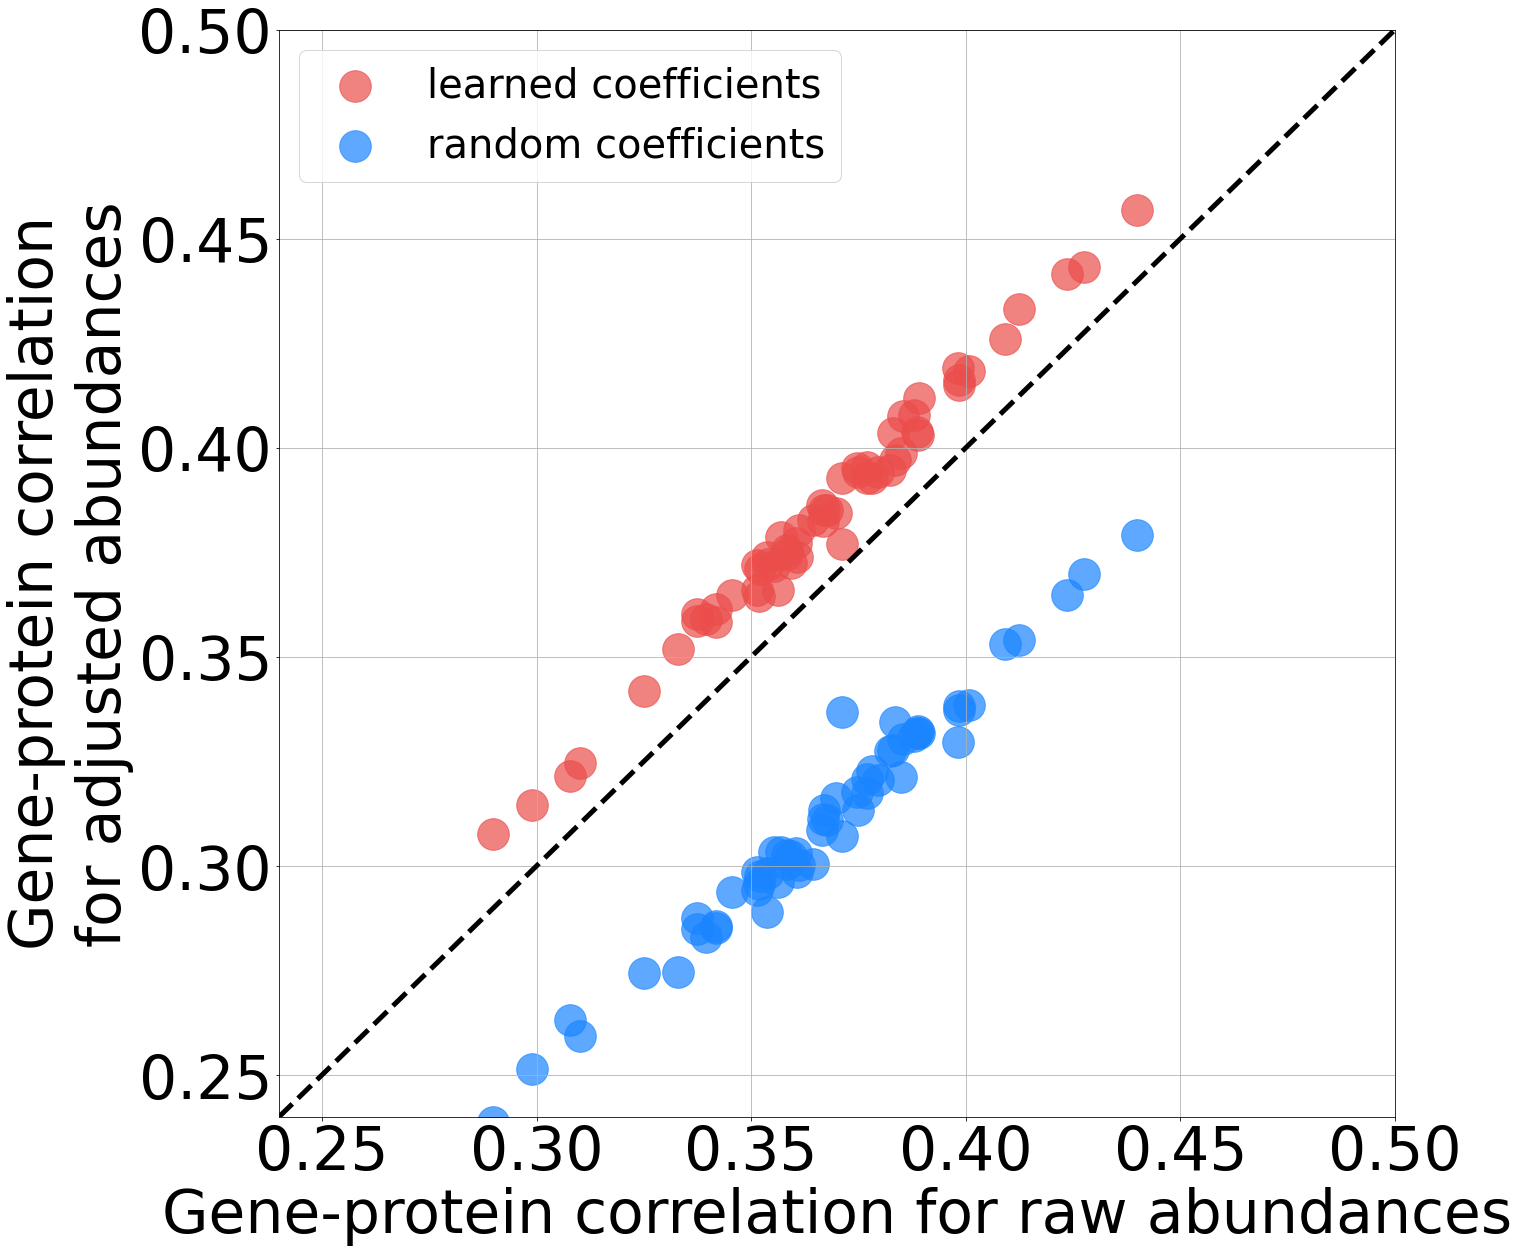

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(20, 20)

SMALL_SIZE = 40
MEDIUM_SIZE = 60
BIGGER_SIZE = 70

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.scatter(np.array(all_correlations_original[0]), 
            np.array(all_correlations_adjusted[0]),
            s = 1000, color = '#eb4d4b', alpha = 0.7, label = 'learned coefficients')

plt.scatter(np.array(all_correlations_original[0]), 
            np.array(all_correlations_random[0]),
            s = 1000, color = '#1A85FF', alpha = 0.7, label = 'random coefficients')


plt.plot([0.24, 0.5], [0.24, 0.5], '--', lw = 5, color = 'Black')
plt.xlim([0.24, 0.5])
plt.ylim([0.24, 0.5])
plt.legend()
plt.xlabel('Gene-protein correlation for raw abundances')
plt.ylabel('Gene-protein correlation \nfor adjusted abundances')
plt.grid()



